# Zadanie 2
- Jakub Karbowski
- Jakub Szymczak

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

## Faktoryzacja LU

```haskell
lu [[a00]] = ([[1]], [[a00]])
lu ((a00:w):rows) = (l, u)
  where n = length w + 1
        v = map head rows
        ap = map tail rows
        (lp, up) = lu $ ap `msubm` (v `outer` w) `mdivs` a00
        l = (1 : replicate (n - 1) 0) : zipWith (:) (map (/a00) v) lp
        u = (a00 : w) : map (0:) up
```

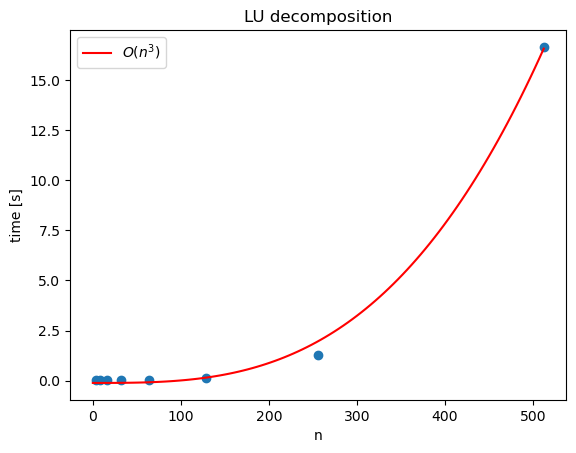

In [12]:
df = pd.read_csv('lu.txt.csv')

def f(x, a, b):
    return a * x**3 + b

x = df['n']
y = df['time']
popt, pcov = scipy.optimize.curve_fit(f, x, y)

plt.plot(x, y, 'o')

x = np.linspace(0, max(x), 100)
plt.plot(x, f(x, *popt), 'r-', label='$O(n^3)$')

plt.legend()
plt.title('LU decomposition')
plt.xlabel('n')
plt.ylabel('time [s]')
plt.show()

Zmierzona złożoność obliczeniowa $O(n^3)$ pokrywa się z teoretyczną.
Implementacja w Haskellu utrudnia pomiar czasu, ponieważ Haskell jest leniwy.
Aby "zmusić" go do obliczeń, liczymy sumę elementów macierzy wynikowych,
co wpływa lekko na czas ($+O(n^2)$ co asymptotycznie nie wpływa na $O(n^3)$).

## Wyznacznik

Dzięki obliczeniu faktoryzacji LU, obliczenie wyznacznika sprowadza się
do wymnożenia elementów na przekątnej macierzy U.

```haskell
det = product . diagonal . snd . lu
```

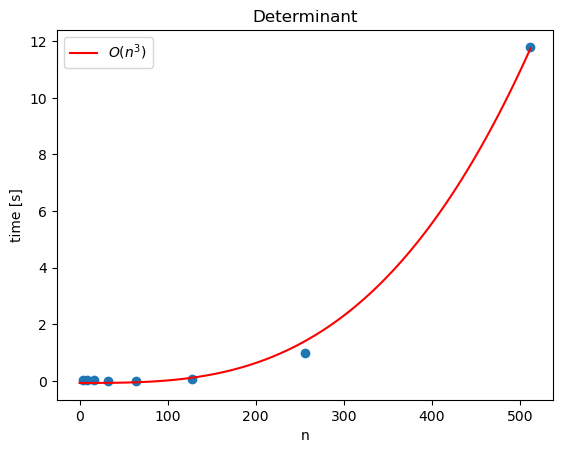

In [13]:
df = pd.read_csv('det.txt.csv')

def f(x, a, b):
    return a * x**3 + b

x = df['n']
y = df['time']
popt, pcov = scipy.optimize.curve_fit(f, x, y)

plt.plot(x, y, 'o')

x = np.linspace(0, max(x), 100)
plt.plot(x, f(x, *popt), 'r-', label='$O(n^3)$')

plt.legend()
plt.title('Determinant')
plt.xlabel('n')
plt.ylabel('time [s]')
plt.show()

Czas jest identyczny jak w przypadku faktoryzacji LU.

## Odwracanie macierzy

Polega na podziale macierzy na 4 równe bloki i rekurencyjnym wywoływaniu aż do przypadku granicznego, gdzie odwrotnością macierzy jednoelementowej jest odwrotność jej jedynej wartości. Dokładne wzory na macierz odwrotną były wyprowadzone na wykładzie i wywodzą się eliminacji Gaussa z macierzą identycznościową z prawej strony.

$$
A^{-1}
=
\left(
\begin{matrix}
A_{11}^{-1} + A_{11}^{-1} A_{12} S_{22}^{-1} A_{21} A_{11}^{-1} & -A_{11}^{-1} A_{12} S_{22}^{-1} \\
-S_{22}^{-1} A_{21} A_{11}^{-1} & S_{22}^{-1}
\end{matrix}
\right)
$$

```python
def invert_matrix_recu(A):
    if A.size > 1:
        A11, A12, A21, A22 = split(A)

        A11_inv = invert_matrix_recu(A11)
        S22 = A22 - A21 * A11_inv * A12
        S22_inv = invert_matrix_recu(S22)

        B11 = A11_inv * (Identity + A12 * S22_inv * A21 * A11_inv)
        B12 = -A11_inv * A12 * S22_inv
        B21 = -S22_inv * A21 * A11_inv
        B22 = S22_inv

        return np.concatenate(
            [np.concatenate([B11, B12], axis=1), np.concatenate([B21, B22], axis=1)], axis=0,)
    else:
        return np.full((1, 1), 1 / A[0][0])
```

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_inverse = pd.read_csv('inverse.csv')

/tmp/ipykernel_15889/4227815796.py:4: RuntimeWarning: invalid value encountered in power
  return a * x**b


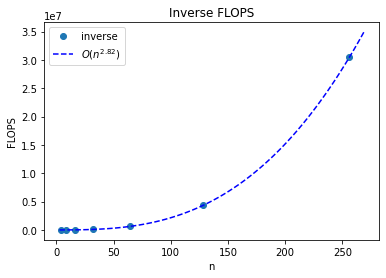

In [7]:
plt.plot(df_inverse['n'], df_inverse['flops_invert'], 'o', label='inverse')

def f(x, a, b):
    return a * x**b

x = df_inverse['n'].astype(np.float64)
y = df_inverse['flops_invert'].astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

plt.legend()
plt.title('Inverse FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

/tmp/ipykernel_15889/1206858637.py:10: RuntimeWarning: invalid value encountered in power
  return a * x**b
/tmp/ipykernel_15889/1206858637.py:23: RuntimeWarning: invalid value encountered in power
  return a * x**b


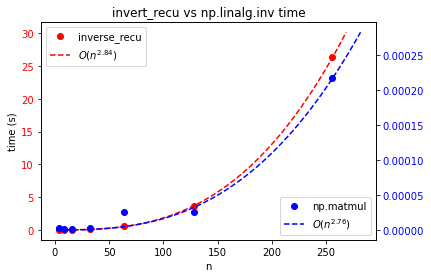

In [10]:
import scipy.optimize

fig, ax1 = plt.subplots()
ax1.set_xlabel('n')
ax1.set_ylabel('time (s)')
ax1.tick_params(axis='y', labelcolor='red')
ax1.plot(df_inverse['n'], df_inverse['time_invert'], 'o', label='inverse_recu', color='red')

def f(x, a, b):
    return a * x**b

x = df_inverse['n'].astype(np.float64)
y = df_inverse['time_invert'].astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
ax1.plot(x, f(x, *popt), 'r--', label=f'$O(n^{{{popt[1]:.2f}}})$')

ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='blue')
ax2.plot(df_inverse['n'], df_inverse['time_np'], 'o', label='np.matmul', color='blue')

def f(x, a, b):
    return a * x**b

x = df_inverse['n'].astype(np.float64)
y = df_inverse['time_np'].astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
ax2.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

ax1.legend()
ax2.legend(loc='lower right')
plt.title('invert_recu vs np.linalg.inv time')
plt.show()

Złożoność odwracania macierzy jest bezpośrednio zależna od złożoności mnożenia macierzy, w algorytmie użyliśmy mnożenia rekurencyjnego(Strassen), więc złożoność odwracania macierzy jest taka jak złożoność mnożenia rekurencyjnego.